# 0.0 Imports

In [1]:
import math
import pandas as pd 
import inflection
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML
print('Ok')

Ok


## Loading data 

In [2]:
df_sales_raw = pd.read_csv("data/train.csv",low_memory = False)
df_store_raw = pd.read_csv('data/store.csv',low_memory = False)

In [3]:
df_store_raw.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [4]:
df_sales_raw.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [5]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on= 'Store')

# 1.0 Data Decription 

## 1.1 Rename columns

In [6]:
df1 = df_raw.copy()
cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
           'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
cols_new = list(map(lambda x: inflection.underscore( x ),cols))

df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print(f'Linhas : {df1.shape[0]}')
print(f'Colunas: {df1.shape[1]}')

Linhas : 1017209
Colunas: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1["date"])

In [9]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
%%timeit -n 5
df1.isna().sum()

231 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## 1.5 Fillout NA 

In [19]:
%%time
# competition_distance  
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x )

# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x["date"].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                            
# promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x["date"].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval      
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',1:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
df1['promo_interval'] = df1['promo_interval'].fillna(0)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval']== 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

CPU times: user 1min 16s, sys: 921 ms, total: 1min 17s
Wall time: 1min 17s


## 1.6 Change Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_sincey_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [14]:
num_atributes = df1.select_dtypes(include = ['int64', 'float64', 'int32'])
cat_atributes = df1.select_dtypes(exclude = ['int64', 'float64', 'int32', 'datetime64[ns]'])

### 1.7.1 Numerical Atributes

In [15]:
%%time
# Central Tenedency - mean, median
ct1 = (pd.DataFrame(num_atributes.apply(np.mean)).T)
ct2 = (pd.DataFrame(num_atributes.apply(np.median)).T)

# Description - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_atributes.apply( np.std )).T
d2 = pd.DataFrame(num_atributes.apply( np.min )).T
d3 = pd.DataFrame(num_atributes.apply( np.max )).T
d4 = pd.DataFrame(num_atributes.apply( lambda x: np.max(x) - np.min(x) )).T
d5 = pd.DataFrame(num_atributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_atributes.apply( lambda x: x.kurtosis() )).T

# concatenate

met = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
met.columns = ['Atributes', 'min','max','range','mean','median','std','skew','kurotosis']
met

CPU times: user 423 ms, sys: 56 μs, total: 423 ms
Wall time: 421 ms


,Atributes,min,max,range,mean,median,std,skew,kurotosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/tmp/ipykernel_6933/2697858400.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

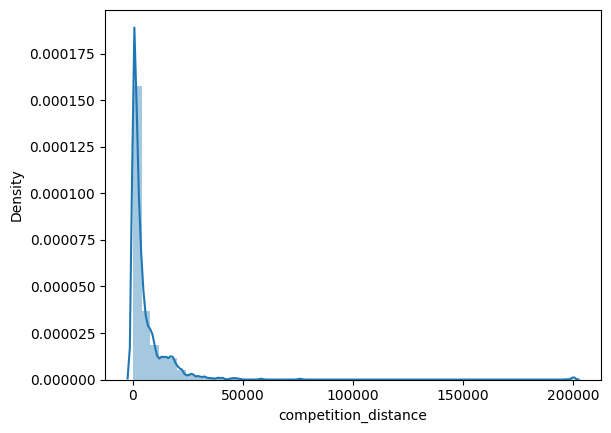

In [16]:
sns.distplot( df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [17]:
cat_atributes.apply(lambda x: x.unique())
cat_atributes.apply(lambda x: x.unique().shape[0])


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='store_type', ylabel='sales'>

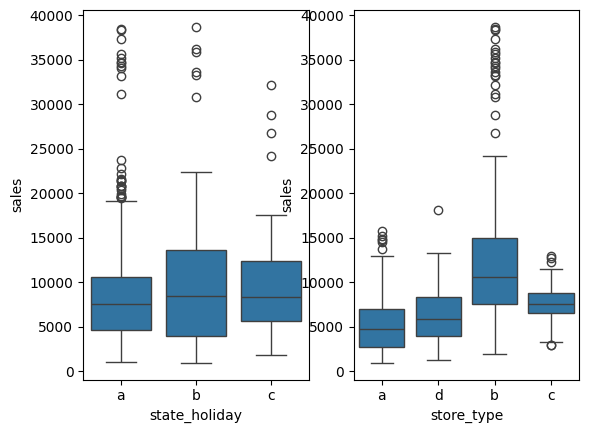

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,2,1)
sns.boxplot( x= 'state_holiday', y= 'sales', data = aux1)

plt.subplot(1,2,2)
sns.boxplot(x= 'store_type', y = 'sales', data = aux1)

# plt.subplot(1,3,3)
# sns.boxplot(x= 'assortment', y = 'sales', data = aux1)



### 1.4 

### 1.4 

### 1.4 

### 1.4 

### 1.4 